## Data Proprocessing

In [198]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [199]:
# 1. 讀檔
tree = ET.parse("O-A0038-003.xml")
root = tree.getroot()
ns = {"cwa": "urn:cwa:gov:tw:cwacommon:0.1"}

# 2. 取出數字
content_text = root.find(".//cwa:Content", ns).text.strip()
# 將換行取代掉，並處理 -999.0E+00-999.0E+00 的情況
raw_lines = content_text.replace("\n", "").replace("\r", "").replace("-999.0E+00-999.0E+00", "-999.0E+00,-999.0E+00")

# 用逗號分隔
tokens = raw_lines.split(",")
# 補上最後一個
tokens.append(tokens[-1])
# print(len(tokens)) # 檢查用，應該為8040

# 3. 轉成小數，並且把 -999 轉成 NaN
def safe_float(x):
    try:
        val = float(x)
        return np.nan if val == -999 else val
    except ValueError:
        return np.nan

values = np.array([safe_float(x) for x in tokens])

# 4. 重新調整尺寸
grid = values.reshape((120, 67))

# 5. 轉為dataframe
df = pd.DataFrame(grid)

# 6. 建立經緯度坐標
lons = 120.00 + np.arange(67) * 0.03
lats = 21.88 + np.arange(120) * 0.03

# 最左下角是最後一列第一個元素，所以需要把緯度翻轉
lats = lats[::-1]

# 建立經緯度網格
lon_grid, lat_grid = np.meshgrid(lons, lats)

# 分成三個維度的資料
dataset = pd.DataFrame({
    "lon": lon_grid.ravel(),
    "lat": lat_grid.ravel(),
    "temp": grid.ravel()
})
dataset


,lon,lat,temp
0,120.00,25.45,NaN
1,120.03,25.45,NaN
2,120.06,25.45,NaN
3,120.09,25.45,NaN
4,120.12,25.45,NaN
...,...,...,...
8035,121.86,21.88,NaN
8036,121.89,21.88,NaN
8037,121.92,21.88,NaN
8038,121.95,21.88,NaN


In [200]:
# 用經緯度查詢溫度
target_lon, target_lat = 120.06, 24.28
tol = 1e-6  # 容忍誤差

result = dataset[
    (abs(dataset["lon"] - target_lon) < tol) & 
    (abs(dataset["lat"] - target_lat) < tol)
]
print(result)

         lon    lat  temp
2615  120.06  24.28  25.3


In [201]:
# 分類資料集
data_cl = dataset[::] # 複製一份資料
data_cl["label"] = data_cl["temp"].apply(lambda x: 0 if pd.isna(x) else 1)
data_cl = data_cl.drop("temp", axis=1)

# 回歸資料集
data_re = dataset[::]
data_re.dropna(subset=["temp"], inplace=True)
data_re = data_re.reset_index(drop=True)

/var/folders/q8/qg42266s5bn3hq7vrzw4nlgc0000gn/T/ipykernel_5181/3030526087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cl["label"] = data_cl["temp"].apply(lambda x: 0 if pd.isna(x) else 1)
/var/folders/q8/qg42266s5bn3hq7vrzw4nlgc0000gn/T/ipykernel_5181/3030526087.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_re.dropna(subset=["temp"], inplace=True)


## Classification

In [202]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

### Show the Original Data

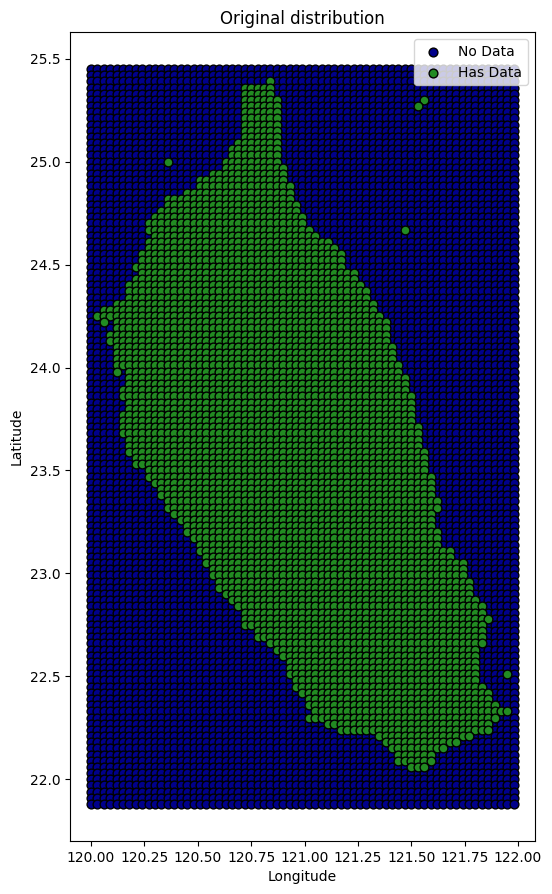

In [203]:
plt.figure(figsize=(6,10.5))

plt.scatter(
    data_cl[data_cl["label"]==0]["lon"],
    data_cl[data_cl["label"]==0]["lat"],
    c="darkblue", edgecolor="k", s=40, label="0"
)

plt.scatter(
    data_cl[data_cl["label"]==1]["lon"],
    data_cl[data_cl["label"]==1]["lat"],
    c="forestgreen", edgecolor="k", s=40, label="1"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Original distribution")
plt.legend(labels=["No Data", "Has Data"])
# plt.colorbar(label="Label (0/1)")
plt.show()


### Model Training and Testing

In [204]:
X = data_cl[["lon", "lat"]]   # 特徵
y = data_cl["label"]          # 標籤

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=114514, stratify=y)
# stratify=y 讓劃分時，訓練集和測試集中的0/1比率盡量和原始資料相同

In [205]:
poly_log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

poly_log_reg.fit(X_train, y_train)

print("訓練集準確率:", poly_log_reg.score(X_train, y_train))
print("測試集準確率:", poly_log_reg.score(X_test, y_test))

訓練集準確率: 0.966728855721393
測試集準確率: 0.957089552238806


### Plotting

/Users/soumahsu/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


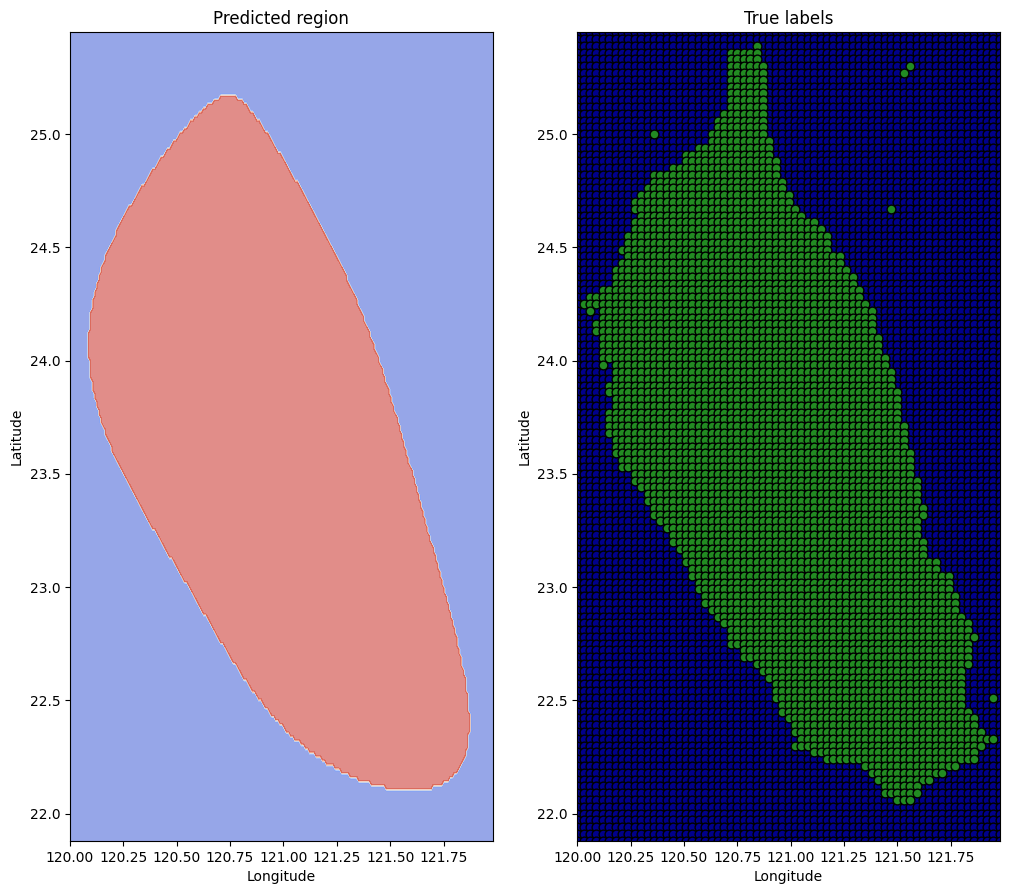

In [206]:
# 假設要預測東經120.06, 北緯24.28
# sample = [[120.06, 24.28]]
# pred = poly_log_reg.predict(sample)
# print("預測 label =", pred[0])

# 建立經緯度網格
xx, yy = np.meshgrid(
    np.linspace(data_cl["lon"].min(), data_cl["lon"].max(), 200),
    np.linspace(data_cl["lat"].min(), data_cl["lat"].max(), 200)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = poly_log_reg.predict(grid_points).reshape(xx.shape)

# 繪圖
fig, ax = plt.subplots(1, 2, figsize=(12,10.5))

# 左圖：預測出的區域
ax[0].contourf(xx, yy, Z, alpha=0.6, cmap="coolwarm")
ax[0].set_title("Predicted region")

# 右圖：正確的資料點
ax[1].set_title("True labels")

ax[1].scatter(
    data_cl[data_cl["label"]==0]["lon"],
    data_cl[data_cl["label"]==0]["lat"],
    c="darkblue", edgecolor="k", s=40, label="0"
)

ax[1].scatter(
    data_cl[data_cl["label"]==1]["lon"],
    data_cl[data_cl["label"]==1]["lat"],
    c="forestgreen", edgecolor="k", s=40, label="1"
)

lon_min, lon_max = data_cl["lon"].min(), data_cl["lon"].max()
lat_min, lat_max = data_cl["lat"].min(), data_cl["lat"].max()

for a in ax:
    a.set_xlabel("Longitude")
    a.set_ylabel("Latitude")
    a.set_xlim(lon_min, lon_max)
    a.set_ylim(lat_min, lat_max)

plt.show()


### Predicting with Random Points

/Users/soumahsu/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/q8/qg42266s5bn3hq7vrzw4nlgc0000gn/T/ipykernel_5181/67636382.py:41: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(random_points[~correct, 0], random_points[~correct, 1],


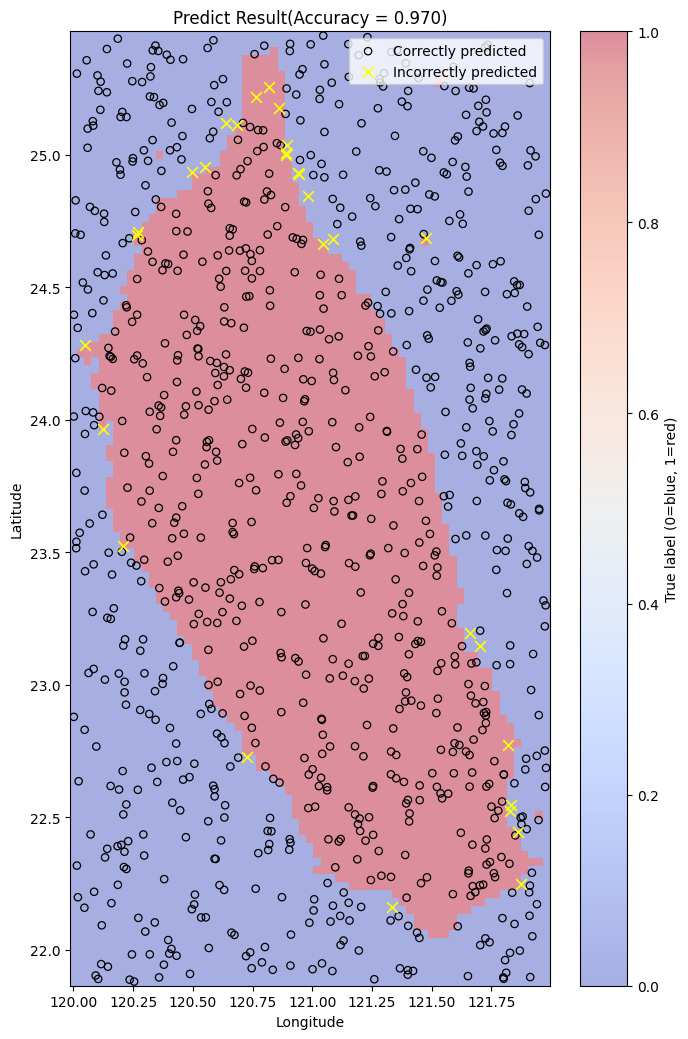

In [207]:
# 背景是正確資料，用半透明色塊表示
pivot = data_cl.pivot(index="lat", columns="lon", values="label").sort_index().sort_index(axis=1)
lats = pivot.index.values     # 升冪
lons = pivot.columns.values   # 升冪
true_grid = pivot.values      # 形狀 [n_lat, n_lon]
xx, yy = np.meshgrid(lons, lats)

# 產生 1000 個隨機經緯度並做預測
rng = np.random.default_rng()
lon_min, lon_max = data_cl["lon"].min(), data_cl["lon"].max()
lat_min, lat_max = data_cl["lat"].min(), data_cl["lat"].max()

random_points = np.column_stack([
    rng.uniform(lon_min, lon_max, 1000),
    rng.uniform(lat_min, lat_max, 1000)
])
y_pred = poly_log_reg.predict(random_points)

# 取這些點的「真實標籤」：用最短距離到
def nearest_label(pt, data):
    d2 = (data["lon"] - pt[0])**2 + (data["lat"] - pt[1])**2
    return int(data.iloc[d2.argmin()]["label"])

y_true = np.array([nearest_label(pt, data_cl) for pt in random_points])

# 計算準確率以及標出正確的點
acc = accuracy_score(y_true, y_pred)
correct = (y_true == y_pred)

# 繪圖：背景為真實標籤色塊；上層標出預測點，強調錯誤點
plt.figure(figsize=(7,10.5))

# 背景：真實標籤（色塊）
plt.pcolormesh(xx, yy, true_grid, shading="nearest", alpha=0.45, cmap="coolwarm")
cbar = plt.colorbar()
cbar.set_label("True label (0=blue, 1=red)")

# 疊點：先畫正確，再畫錯誤
plt.scatter(random_points[correct, 0], random_points[correct, 1],
            facecolors="none", edgecolors="k", s=28, linewidths=0.9, label="Correctly predicted")
plt.scatter(random_points[~correct, 0], random_points[~correct, 1],
            c="yellow", edgecolors="k", marker="x", s=60, linewidths=1.2, label="Incorrectly predicted")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Predict Result(Accuracy = {acc:.3f})")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


## Regression - Model Training

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Show the Original Data

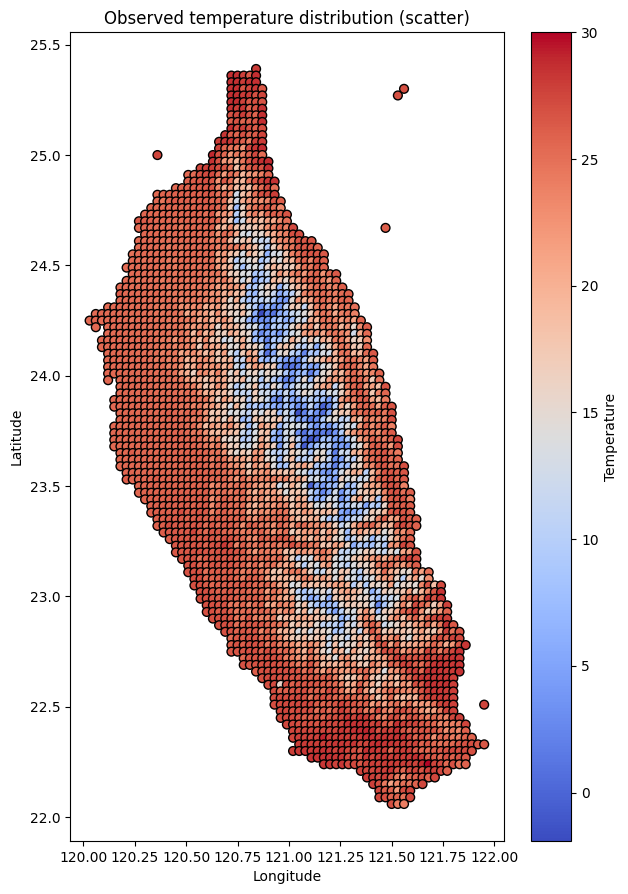

In [209]:
plt.figure(figsize=(7,10.5))
sc = plt.scatter(data_re["lon"], data_re["lat"], 
                 c=data_re["temp"], cmap="coolwarm", s=40, edgecolor="k")

plt.colorbar(sc, label="Temperature")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Observed temperature distribution (scatter)")
plt.show()

### Model Training & Testing

In [215]:
X = data_re[["lon", "lat"]]
y = data_re["temp"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=114514)

In [211]:
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [212]:
# 假設要預測東經120.06, 北緯24.28
sample = [[120.06, 24.28]]
pred = rf_reg.predict(sample)
print(f'預測 temp ={pred[0]}')

預測 temp =25.418000000000035


/Users/soumahsu/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Plotting

MSE: 5.191979990844066
R²: 0.8524999569310997


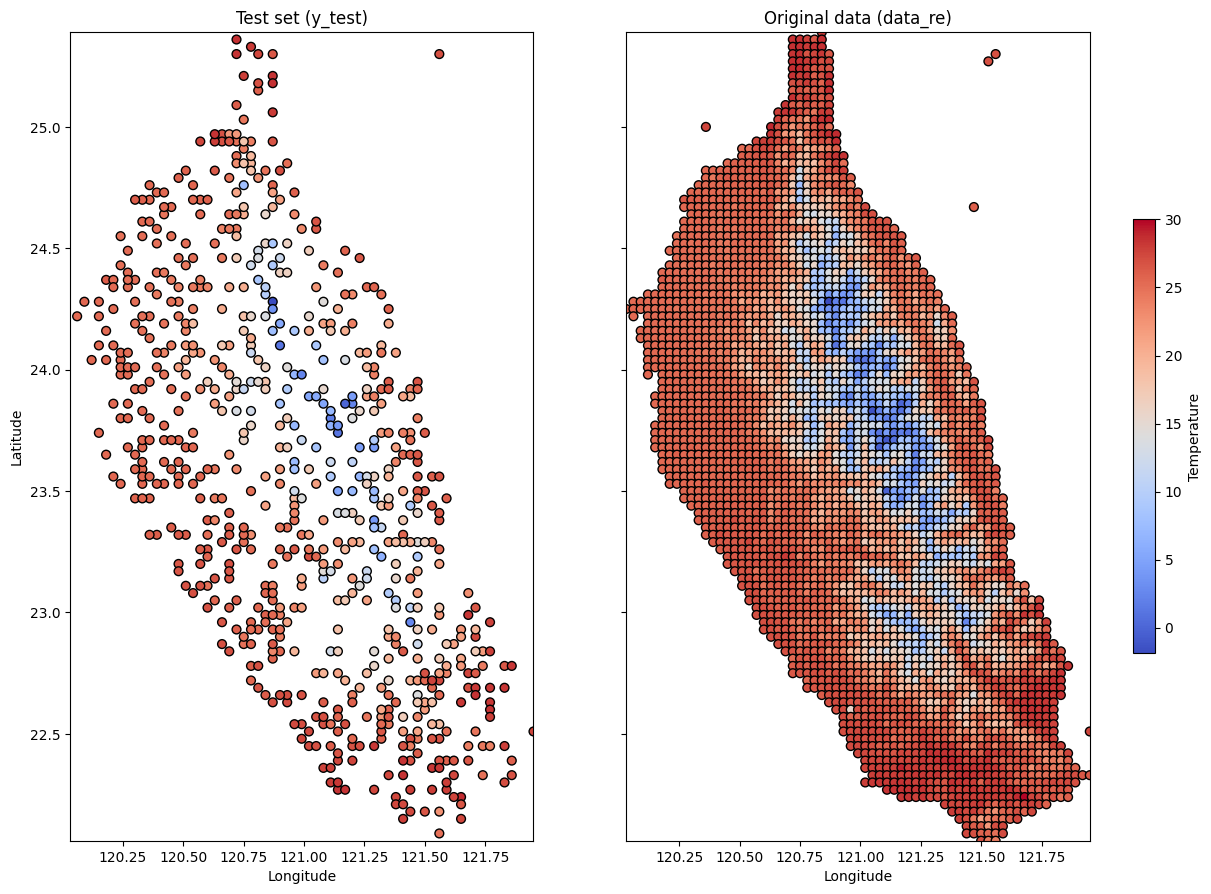

In [213]:
y_pred = rf_reg.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

fig, ax = plt.subplots(1, 2, figsize=(14,10.5), sharey=True)

# 設定顏色範圍一致
vmin = data_re["temp"].min()
vmax = data_re["temp"].max()

# 左圖：y_test
sc1 = ax[0].scatter(X_test["lon"], X_test["lat"], 
                    c=y_test, cmap="coolwarm", s=40, edgecolor="k",
                    vmin=vmin, vmax=vmax)
ax[0].set_title("Test set (y_test)")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

# 右圖：完整 data_re
sc2 = ax[1].scatter(data_re["lon"], data_re["lat"], 
                    c=data_re["temp"], cmap="coolwarm", s=40, edgecolor="k",
                    vmin=vmin, vmax=vmax)
ax[1].set_title("Original data (data_re)")
ax[1].set_xlabel("Longitude")

# 共用一個 colorbar
cbar = fig.colorbar(sc2, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label("Temperature")

# 固定座標範圍
lon_min, lon_max = data_re["lon"].min(), data_re["lon"].max()
lat_min, lat_max = data_re["lat"].min(), data_re["lat"].max()
for a in ax:
    a.set_xlim(lon_min, lon_max)
    a.set_ylim(lat_min, lat_max)

# plt.tight_layout()
plt.show()

### Predicting with Random Points

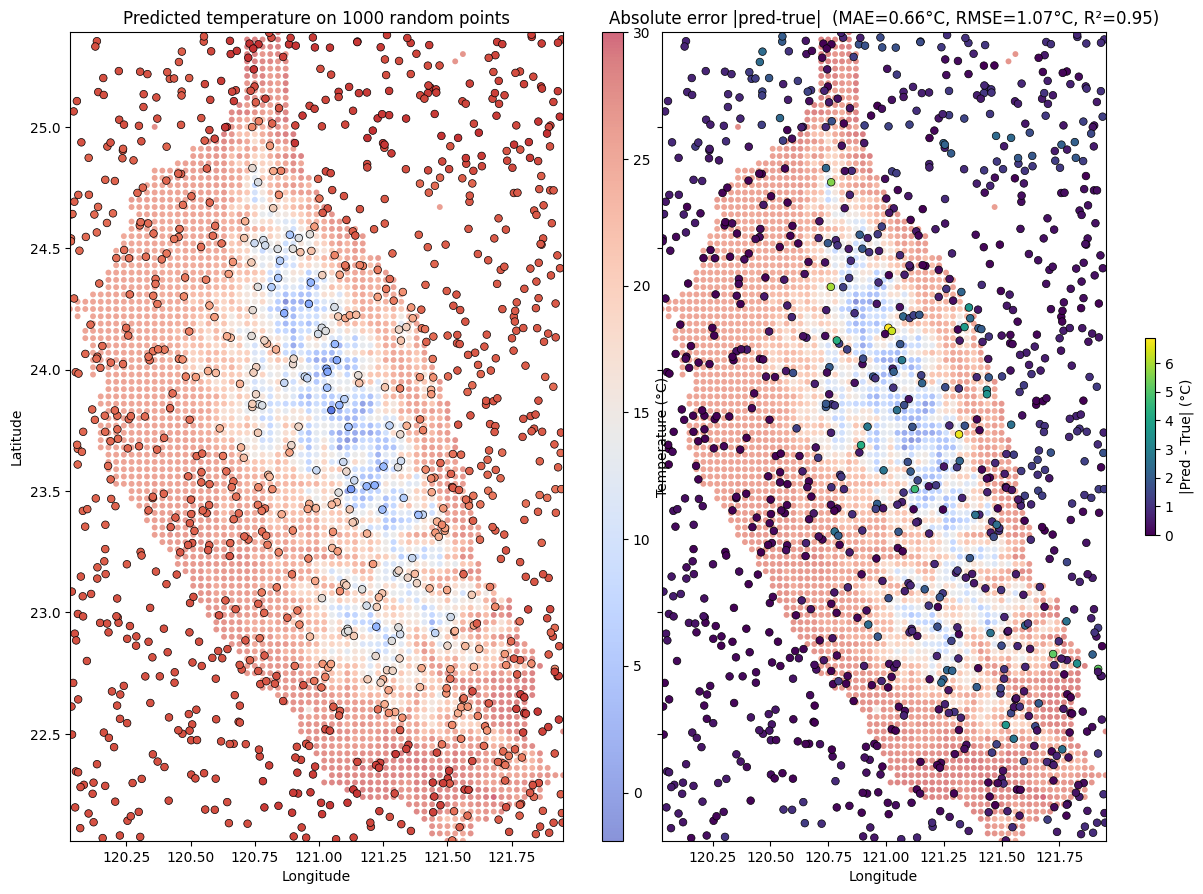

In [214]:
# 隨機取1000點
lon_min, lon_max = data_re["lon"].min(), data_re["lon"].max()
lat_min, lat_max = data_re["lat"].min(), data_re["lat"].max()

rng = np.random.default_rng()  # 不設seed
random_points = np.column_stack([
    rng.uniform(lon_min, lon_max, 1000),
    rng.uniform(lat_min, lat_max, 1000)
])
X_new = pd.DataFrame(random_points, columns=["lon","lat"])

# 預測
y_pred = rf_reg.predict(X_new)

# 取真實值（最近鄰）
try:
    from scipy.spatial import cKDTree
    tree = cKDTree(data_re[["lon","lat"]].values)
    dist, idx = tree.query(random_points, k=1)
    y_true = data_re["temp"].values[idx]
except Exception:
    def nearest_temp(pt):
        d2 = (data_re["lon"] - pt[0])**2 + (data_re["lat"] - pt[1])**2
        return float(data_re.iloc[d2.argmin()]["temp"])
    y_true = np.array([nearest_temp(pt) for pt in random_points])

# 指標
mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

# 畫圖：背景用「真實資料散點」；上層疊隨機點
fig, ax = plt.subplots(1, 2, figsize=(14,10.5), sharey=True)

# 統一顏色範圍（依真實 data_re 的溫度）
vmin = np.nanmin(data_re["temp"].values)
vmax = np.nanmax(data_re["temp"].values)

# 左：背景真實值（散點） + 預測點著色為「預測溫度」
bg1 = ax[0].scatter(data_re["lon"], data_re["lat"],
                    c=data_re["temp"], cmap="coolwarm", s=18, alpha=0.6,
                    edgecolor="none", vmin=vmin, vmax=vmax)
fg1 = ax[0].scatter(random_points[:,0], random_points[:,1],
                    c=y_pred, cmap="coolwarm", s=30, edgecolor="k",
                    vmin=vmin, vmax=vmax, linewidths=0.5)
ax[0].set_title("Predicted temperature on 1000 random points")
ax[0].set_xlabel("Longitude"); ax[0].set_ylabel("Latitude")

# 右：背景真實值（散點） + 預測點著色為「絕對誤差」
err = np.abs(y_pred - y_true)
bg2 = ax[1].scatter(data_re["lon"], data_re["lat"],
                    c=data_re["temp"], cmap="coolwarm", s=18, alpha=0.6,
                    edgecolor="none", vmin=vmin, vmax=vmax)
fg2 = ax[1].scatter(random_points[:,0], random_points[:,1],
                    c=err, cmap="viridis", s=30, edgecolor="k", linewidths=0.5)
ax[1].set_title(f"Absolute error |pred-true|  (MAE={mae:.2f}°C, RMSE={rmse:.2f}°C, R²={r2:.2f})")
ax[1].set_xlabel("Longitude")

# 座標範圍一致 & 只用一條溫度色條
for a in ax:
    a.set_xlim(lon_min, lon_max)
    a.set_ylim(lat_min, lat_max)
# 取得兩張子圖的位置
pos0 = ax[0].get_position()
pos1 = ax[1].get_position()

# 中線 x 位置、色條寬度
mid_x   = 0.5 * (pos0.x1 + pos1.x0)   # 兩張圖中間
cb_w    = 0.015                       # 色條寬度
cb_y0   = min(pos0.y0, pos1.y0)       # 與子圖同高
cb_y1   = max(pos0.y1, pos1.y1)
cb_h    = cb_y1 - cb_y0

# 把溫度色條放在中間
cax_mid = fig.add_axes([mid_x - cb_w/2, cb_y0, cb_w, cb_h])
cbar_temp = fig.colorbar(bg1, cax=cax_mid)
cbar_temp.set_label("Temperature (°C)")

# 誤差色條放在右邊
cbar_err = fig.colorbar(fg2, ax=ax[1], fraction=0.02, pad=0.08)
cbar_err.set_label("|Pred - True| (°C)")

# plt.tight_layout()
plt.show()